# Continuous Control

---

In this notebook, you will learn how to use the Unity ML-Agents environment for the second project of the [Deep Reinforcement Learning Nanodegree](https://www.udacity.com/course/deep-reinforcement-learning-nanodegree--nd893) program.

### 1. Start the Environment

We begin by importing the necessary packages.  If the code cell below returns an error, please revisit the project instructions to double-check that you have installed [Unity ML-Agents](https://github.com/Unity-Technologies/ml-agents/blob/master/docs/Installation.md) and [NumPy](http://www.numpy.org/).

In [1]:
%load_ext autoreload
%autoreload 2

In [10]:
import sys
sys.path.insert(1, 'scripts/')  # TODO: insert at 1, 0 is the script path (or '' in REPL)

from unityagents import UnityEnvironment
import numpy as np
import torch
from collections import deque
import shutil
import os
import matplotlib.pyplot as plt
%matplotlib inline

from d4pg_agent import D4PG_Agent
from params import Params
from logger import Logger

Next, we will start the environment!  **_Before running the code cell below_**, change the `file_name` parameter to match the location of the Unity environment that you downloaded.

- **Mac**: `"path/to/Reacher.app"`
- **Windows** (x86): `"path/to/Reacher_Windows_x86/Reacher.exe"`
- **Windows** (x86_64): `"path/to/Reacher_Windows_x86_64/Reacher.exe"`
- **Linux** (x86): `"path/to/Reacher_Linux/Reacher.x86"`
- **Linux** (x86_64): `"path/to/Reacher_Linux/Reacher.x86_64"`
- **Linux** (x86, headless): `"path/to/Reacher_Linux_NoVis/Reacher.x86"`
- **Linux** (x86_64, headless): `"path/to/Reacher_Linux_NoVis/Reacher.x86_64"`

For instance, if you are using a Mac, then you downloaded `Reacher.app`.  If this file is in the same folder as the notebook, then the line below should appear as follows:
```
env = UnityEnvironment(file_name="Reacher.app")
```

In [3]:
# env = UnityEnvironment(file_name='Crawler_Windows_x86_64/Crawler.exe')
env = UnityEnvironment(file_name='Crawler_Windows_x86_64/Crawler.exe', no_graphics=True)

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: CrawlerBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 129
        Number of stacked Vector Observation: 1
        Vector Action space type: continuous
        Vector Action space size (per agent): 20
        Vector Action descriptions: , , , , , , , , , , , , , , , , , , , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [4]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

### 2. Examine the State and Action Spaces

In this environment, a double-jointed arm can move to target locations. A reward of `+0.1` is provided for each step that the agent's hand is in the goal location. Thus, the goal of your agent is to maintain its position at the target location for as many time steps as possible.

The observation space consists of `33` variables corresponding to position, rotation, velocity, and angular velocities of the arm.  Each action is a vector with four numbers, corresponding to torque applicable to two joints.  Every entry in the action vector must be a number between `-1` and `1`.

Run the code cell below to print some information about the environment.

In [5]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])

Number of agents: 12
Size of each action: 20
There are 12 agents. Each observes a state with length: 129
The state for the first agent looks like: [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  2.25000000e+00
  1.00000000e+00  0.00000000e+00  1.78813934e-07  0.00000000e+00
  1.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  6.06093168e-01 -1.42857209e-01 -6.06078804e-01  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  1.33339906e+00 -1.42857209e-01
 -1.33341408e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
 -6.0609

### 3. Take Random Actions in the Environment

In the next code cell, you will learn how to use the Python API to control the agent and receive feedback from the environment.

Once this cell is executed, you will watch the agent's performance, if it selects an action at random with each time step.  A window should pop up that allows you to observe the agent, as it moves through the environment.  

Of course, as part of the project, you'll have to change the code so that the agent is able to use its experience to gradually choose better actions when interacting with the environment!

In [6]:
# env_info = env.reset(train_mode=False)[brain_name]     # reset the environment    
# states = env_info.vector_observations                  # get the current state (for each agent)
# scores = np.zeros(num_agents)                          # initialize the score (for each agent)
# while True:
#     actions = np.random.randn(num_agents, action_size) # select an action (for each agent)
#     actions = np.clip(actions, -1, 1)                  # all actions between -1 and 1
#     env_info = env.step(actions)[brain_name]           # send all actions to tne environment
#     next_states = env_info.vector_observations         # get next state (for each agent)
#     rewards = env_info.rewards                         # get reward (for each agent)
#     dones = env_info.local_done                        # see if episode finished
#     scores += env_info.rewards                         # update the score (for each agent)
#     states = next_states                               # roll over states to next time step
#     if np.any(dones):                                  # exit loop if episode finished
#         break
# print('Total score (averaged over agents) this episode: {}'.format(np.mean(scores)))

When finished, you can close the environment.

In [7]:
# env.close()

### 4. It's Your Turn!

Now it's your turn to train your own agent to solve the environment!  When training the environment, set `train_mode=True`, so that the line for resetting the environment looks like the following:
```python
env_info = env.reset(train_mode=True)[brain_name]
```

While training is taking place, statistics on agent performance are available from Tensorboard. To launch it use:
```python
cd <PROJECT_DIR>
tensorboard --logdir=runs
```

In [12]:
def d4pg(params=Params(), logger=Logger()):
    
    env_info = env.reset(train_mode=True)[brain_name]
    action_size = brain.vector_action_space_size
    state_size = env_info.vector_observations.shape[1]
    logger.initialize(agent, state_size, action_size)
    
    for i_episode in range(1, params.n_episodes+1):
        env_info = env.reset(train_mode=True)[brain_name]  # reset the environment
        states = env_info.vector_observations              # get the current state
        agent.reset()
        score = np.zeros(len(env_info.agents))
            
        for t in range(params.max_t):                             
            
            # Perform actions from each agent's policy network (clipped actions [0, -1])
            actions = [ agent.act(state) for state in states ]  
            actions = np.stack(actions)            
            env_info = env.step(actions)[brain_name]      
            next_states, rewards, dones = env_info.vector_observations, env_info.rewards, env_info.local_done
            agent.step(states, actions, rewards, next_states, dones, clear_nstep_buffer=(t==0))
            states = next_states
            score += (sum(rewards) / len(rewards))  # ALT METRIC: Max
            
            # Prevent agent from learning NaN rewards
            has_NAN_in_rewards = np.isnan(rewards)
            if any(has_NAN_in_rewards):
                rewards = np.where(np.isnan(rewards), 0, rewards)
                print("NaN Reward Found! Converting to R=0 instead...")
            
            # Allow crawler to keep resetting if fall, but reset score to 0 if so
            score += np.array(rewards)
            score = np.where(dones, 0, score)
            
            # Break if any of the agent is done
            if all(dones):   # any()
                break 
        
        # Print crucial results for progress tracking
        if agent.memory_buffer_prefilled():
            
            logger.log_stats(i_episode, float(score.mean()), agent.actor_loss, agent.critic_loss)
            print('\rEpisode {}\ Score: {:.2f}'.format(i_episode, logger.scores_deque[-1]), end="")

            if i_episode % params.save_every == 0:
                logger.save_weights(i_episode)

            if i_episode % params.print_every == 0:
                print('\rEpisode {}: \tActor Loss: {:.2f} \tCritic Loss: {:.2f} \n\t\tAverage Score: {:.2f}\n'
                      .format(i_episode, np.mean(logger.actor_loss_deque), np.mean(logger.critic_loss_deque), np.mean(logger.scores_deque)))

                if np.mean(logger.scores_deque) >= params.target_score:
                    print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.2f}'
                          .format(i_episode, np.mean(logger.scores_deque)))
                    if params.terminate_on_target_score:
                        break

    # Plot graphs & save final weights
    logger.save_weights(i_episode)
    if params.plot_stats:
        logger.plot_stats()
    logger.log_overall_perf_tb()
    return logger.scores_list


=============== NETWORKS ===============
actor_local Actor(
  (bn0): BatchNorm1d(129, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=129, out_features=256, bias=True)
  (bn1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (bn2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc3): Linear(in_features=128, out_features=20, bias=True)
)
actor_target Actor(
  (bn0): BatchNorm1d(129, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=129, out_features=256, bias=True)
  (bn1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (bn2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc3): Linear(in_features=128, out_features=20, bias=True)
)
criti

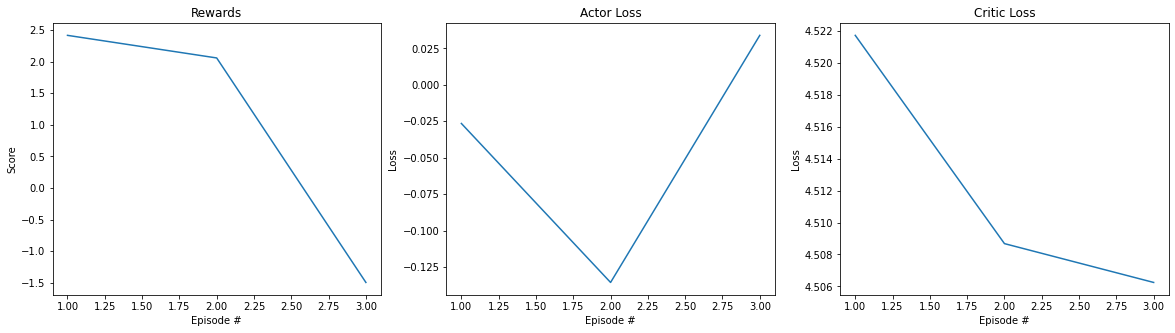

[2.416318150909824, 2.0585136755414877, -1.4960897163513842]

In [14]:
##################
# QUICK TEST
##################

# Params Override: Initialized in params.py
params = Params()
params.verbose = True
params.random_seed = 0
params.n_episodes=3
params.max_t = 100
params.print_every = 100
params.save_every = 100
params.prefill_memory_qty=0
params.terminate_on_target_score = True
params.plot_stats = True
params.lr_actor = 5e-4                  
params.lr_critic = 1e-3  
params.vmin = -20
params.vmax = 20


#### MAIN #####
logger = Logger(params)
agent = D4PG_Agent(state_size, action_size, params=params)
d4pg(params, logger)

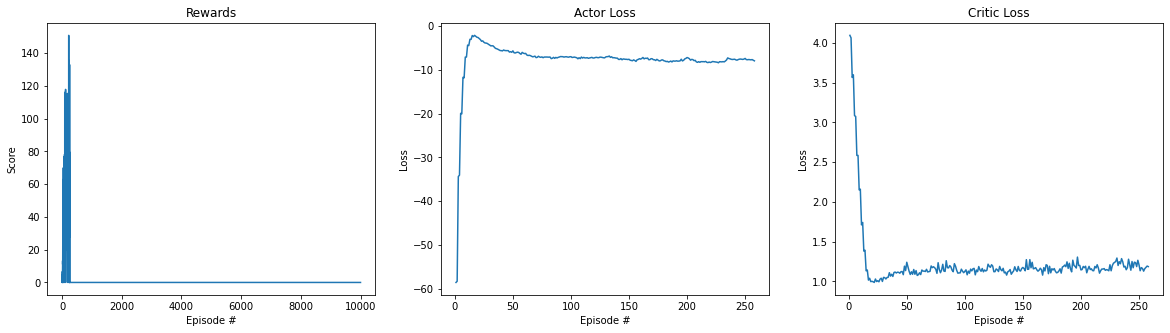

In [105]:
def plot_graph(logger):
    
    score_arr  = np.array(logger.scores_list)
    score_arr[score_arr < 0] = 0
    _, axs = plt.subplots(1, 3, figsize=(20, 5))

    # Scores
    axs[0].plot(np.arange(1, len(logger.scores_list)+1), score_arr)
    axs[0].set(xlabel='Episode #', ylabel='Score')
    axs[0].set_title('Rewards')
        
    # Actor Loss
    axs[1].plot(np.arange(1, len(logger.actor_loss_list)+1), logger.actor_loss_list)
    axs[1].set(xlabel='Episode #', ylabel='Loss')
    axs[1].set_title('Actor Loss')
    
    # Critic Loss
    axs[2].plot(np.arange(1, len(logger.critic_loss_list)+1), logger.critic_loss_list)
    axs[2].set(xlabel='Episode #', ylabel='Loss')
    axs[2].set_title('Critic Loss')
    plt.show()
    
plot_graph(logger)


=============== HYPERPARAMS ===============
DEVICE:  cuda:0
RANDOM SEED:  0
BUFFER_SIZE:  300000
BATCH_SIZE:  128
GAMMA:  0.99
TAU:  0.001
LR_ACTOR:  0.0005
LR_CRITIC:  0.001
WEIGHT_DECAY:  0.0001
HARD_UPDATE:  True
LEARN_EVERY:  1
HARD_WEIGHTS_UPDATE_EVERY:  350
N_STEP_BOOTSTRAP:  5
VMIN:  0
VMAX:  100
NUM_ATOMS:  100

Prefilling Replay Memory Buffer: 5004 / 5000
 ===== Replay Buffer prefilled. Agent will begin learning. =====

Episode 100: 	Actor Loss: -44.62 	Critic Loss: 4.46 
		Average Score: 0.62

Episode 200: 	Actor Loss: -38.12 	Critic Loss: 4.29 
		Average Score: 0.86

Episode 300: 	Actor Loss: -34.70 	Critic Loss: 4.19 
		Average Score: 0.82

Episode 400: 	Actor Loss: -31.97 	Critic Loss: 4.09 
		Average Score: 2.52

Episode 500: 	Actor Loss: -30.36 	Critic Loss: 3.99 
		Average Score: 3.15

Episode 600: 	Actor Loss: -30.58 	Critic Loss: 3.91 
		Average Score: 3.71

Episode 700: 	Actor Loss: -31.71 	Critic Loss: 3.81 
		Average Score: 9.80

Episode 800: 	Actor Loss: -34.74 	

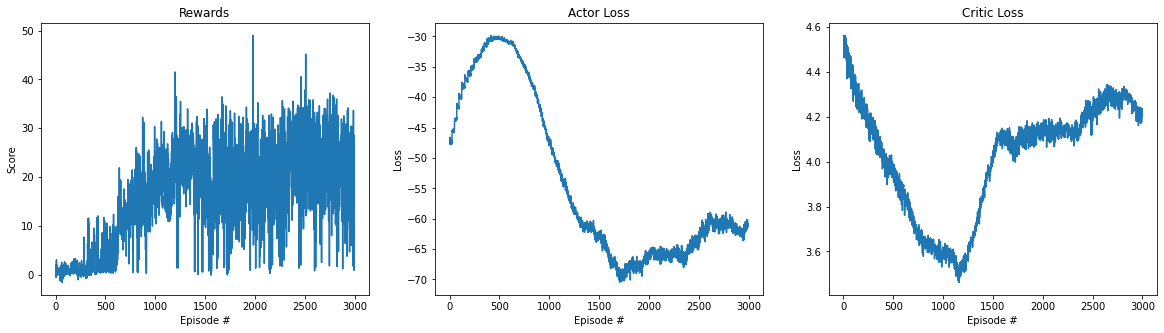


=============== HYPERPARAMS ===============
DEVICE:  cuda:0
RANDOM SEED:  0
BUFFER_SIZE:  300000
BATCH_SIZE:  128
GAMMA:  0.99
TAU:  0.001
LR_ACTOR:  0.0005
LR_CRITIC:  0.001
WEIGHT_DECAY:  0.0001
HARD_UPDATE:  True
LEARN_EVERY:  1
HARD_WEIGHTS_UPDATE_EVERY:  350
N_STEP_BOOTSTRAP:  5
VMIN:  0
VMAX:  200
NUM_ATOMS:  100

Prefilling Replay Memory Buffer: 5004 / 5000
 ===== Replay Buffer prefilled. Agent will begin learning. =====

Episode 100: 	Actor Loss: -87.52 	Critic Loss: 4.46 
		Average Score: 0.71

Episode 200: 	Actor Loss: -75.37 	Critic Loss: 4.31 
		Average Score: 0.64

Episode 300: 	Actor Loss: -65.75 	Critic Loss: 4.19 
		Average Score: 0.56

Episode 400: 	Actor Loss: -56.00 	Critic Loss: 4.07 
		Average Score: 2.13

Episode 500: 	Actor Loss: -48.08 	Critic Loss: 3.94 
		Average Score: 1.90

Episode 600: 	Actor Loss: -42.36 	Critic Loss: 3.81 
		Average Score: 2.69

Episode 700: 	Actor Loss: -36.23 	Critic Loss: 3.63 
		Average Score: 3.55

Episode 800: 	Actor Loss: -32.07 	

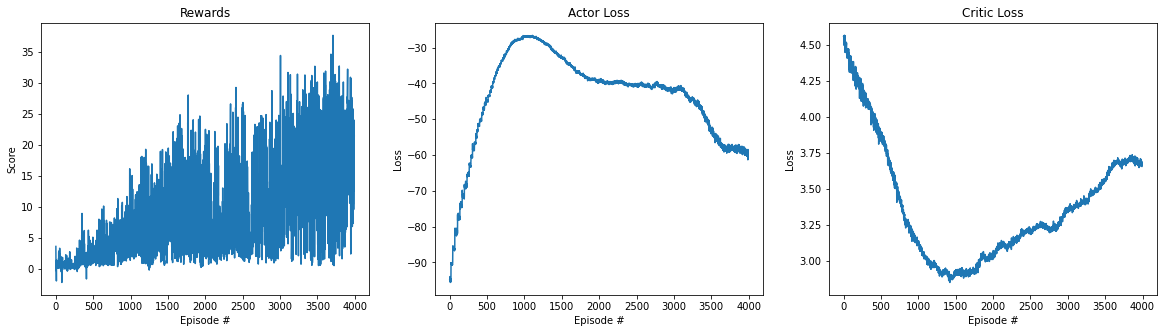


=============== HYPERPARAMS ===============
DEVICE:  cuda:0
RANDOM SEED:  0
BUFFER_SIZE:  300000
BATCH_SIZE:  128
GAMMA:  0.99
TAU:  0.001
LR_ACTOR:  0.0005
LR_CRITIC:  0.001
WEIGHT_DECAY:  0.0001
HARD_UPDATE:  True
LEARN_EVERY:  1
HARD_WEIGHTS_UPDATE_EVERY:  350
N_STEP_BOOTSTRAP:  5
VMIN:  0
VMAX:  500
NUM_ATOMS:  100

Prefilling Replay Memory Buffer: 5004 / 5000
 ===== Replay Buffer prefilled. Agent will begin learning. =====

Episode 100: 	Actor Loss: -223.58 	Critic Loss: 4.48 
		Average Score: 0.51

Episode 200: 	Actor Loss: -193.71 	Critic Loss: 4.33 
		Average Score: 0.02

Episode 300: 	Actor Loss: -168.45 	Critic Loss: 4.19 
		Average Score: 0.22

Episode 400: 	Actor Loss: -144.46 	Critic Loss: 4.08 
		Average Score: 0.16

Episode 500: 	Actor Loss: -122.17 	Critic Loss: 3.96 
		Average Score: 0.81

Episode 600: 	Actor Loss: -96.61 	Critic Loss: 3.77 
		Average Score: 1.20

Episode 700: 	Actor Loss: -77.04 	Critic Loss: 3.56 
		Average Score: 0.25

Episode 800: 	Actor Loss: -67

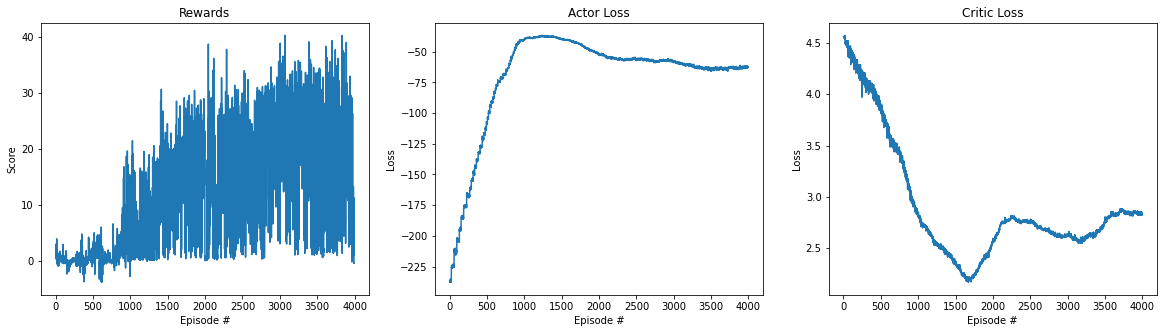


=============== HYPERPARAMS ===============
DEVICE:  cuda:0
RANDOM SEED:  0
BUFFER_SIZE:  300000
BATCH_SIZE:  128
GAMMA:  0.99
TAU:  0.001
LR_ACTOR:  0.0005
LR_CRITIC:  0.001
WEIGHT_DECAY:  0.0001
HARD_UPDATE:  True
LEARN_EVERY:  1
HARD_WEIGHTS_UPDATE_EVERY:  350
N_STEP_BOOTSTRAP:  5
VMIN:  0
VMAX:  1000
NUM_ATOMS:  100

Prefilling Replay Memory Buffer: 5004 / 5000
 ===== Replay Buffer prefilled. Agent will begin learning. =====

Episode 100: 	Actor Loss: -434.58 	Critic Loss: 4.44 
		Average Score: 0.57

Episode 200: 	Actor Loss: -337.72 	Critic Loss: 4.22 
		Average Score: 0.47

Episode 300: 	Actor Loss: -237.32 	Critic Loss: 3.93 
		Average Score: 0.74

Episode 400: 	Actor Loss: -169.88 	Critic Loss: 3.64 
		Average Score: 0.65

Episode 500: 	Actor Loss: -118.96 	Critic Loss: 3.29 
		Average Score: 0.33

Episode 600: 	Actor Loss: -86.99 	Critic Loss: 3.00 
		Average Score: 2.74

Episode 700: 	Actor Loss: -71.98 	Critic Loss: 2.83 
		Average Score: 1.87

Episode 800: 	Actor Loss: -6

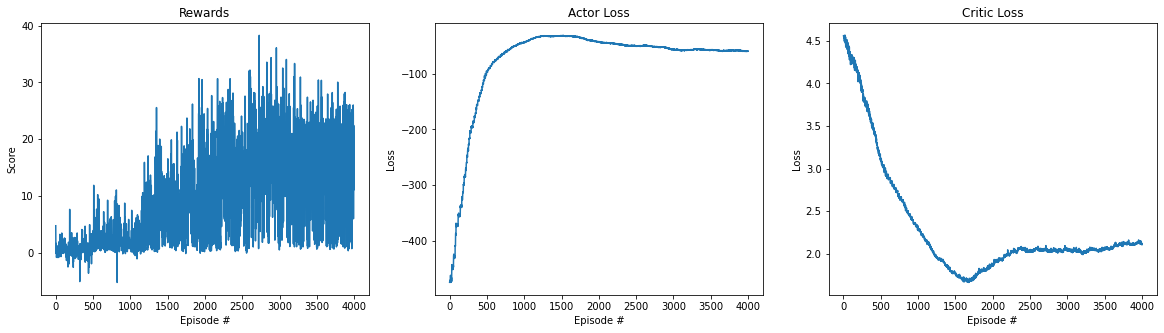


=============== HYPERPARAMS ===============
DEVICE:  cuda:0
RANDOM SEED:  0
BUFFER_SIZE:  300000
BATCH_SIZE:  128
GAMMA:  0.99
TAU:  0.001
LR_ACTOR:  0.0005
LR_CRITIC:  0.001
WEIGHT_DECAY:  0.0001
HARD_UPDATE:  True
LEARN_EVERY:  1
HARD_WEIGHTS_UPDATE_EVERY:  350
N_STEP_BOOTSTRAP:  5
VMIN:  0
VMAX:  2000
NUM_ATOMS:  100

Prefilling Replay Memory Buffer: 5004 / 5000
 ===== Replay Buffer prefilled. Agent will begin learning. =====

Episode 100: 	Actor Loss: -850.21 	Critic Loss: 4.43 
		Average Score: 0.57

Episode 200: 	Actor Loss: -707.18 	Critic Loss: 4.25 
		Average Score: 0.31

Episode 300: 	Actor Loss: -595.37 	Critic Loss: 4.11 
		Average Score: 0.67

Episode 400: 	Actor Loss: -479.35 	Critic Loss: 3.91 
		Average Score: 1.21

Episode 500: 	Actor Loss: -392.20 	Critic Loss: 3.73 
		Average Score: 0.52

Episode 600: 	Actor Loss: -316.13 	Critic Loss: 3.52 
		Average Score: 0.25

Episode 700: 	Actor Loss: -248.94 	Critic Loss: 3.30 
		Average Score: 1.53

Episode 800: 	Actor Loss: 

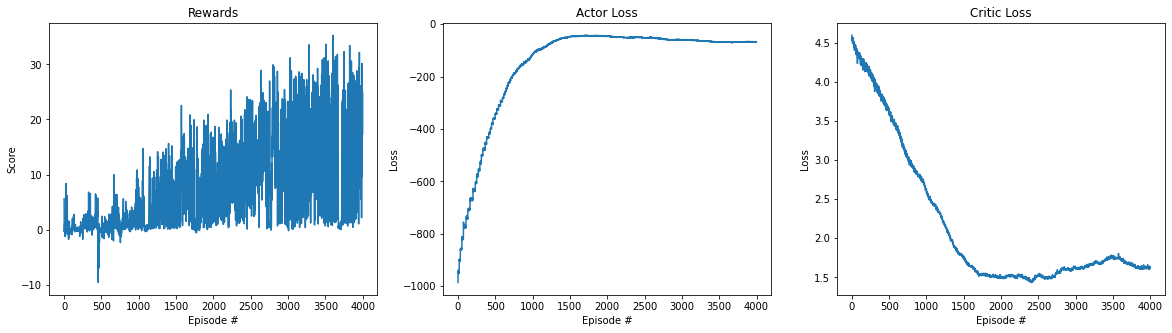


=============== HYPERPARAMS ===============
DEVICE:  cuda:0
RANDOM SEED:  0
BUFFER_SIZE:  300000
BATCH_SIZE:  128
GAMMA:  0.99
TAU:  0.001
LR_ACTOR:  0.0005
LR_CRITIC:  0.001
WEIGHT_DECAY:  0.0001
HARD_UPDATE:  True
LEARN_EVERY:  1
HARD_WEIGHTS_UPDATE_EVERY:  350
N_STEP_BOOTSTRAP:  5
VMIN:  0
VMAX:  5000
NUM_ATOMS:  100

Prefilling Replay Memory Buffer: 5004 / 5000
 ===== Replay Buffer prefilled. Agent will begin learning. =====

Episode 100: 	Actor Loss: -2149.93 	Critic Loss: 4.41 
		Average Score: 0.62

Episode 200: 	Actor Loss: -1765.62 	Critic Loss: 4.18 
		Average Score: 0.19

Episode 300: 	Actor Loss: -1443.84 	Critic Loss: 4.04 
		Average Score: 0.71

Episode 400: 	Actor Loss: -1160.08 	Critic Loss: 3.86 
		Average Score: 1.65

Episode 500: 	Actor Loss: -903.40 	Critic Loss: 3.66 
		Average Score: 0.95

Episode 600: 	Actor Loss: -695.01 	Critic Loss: 3.43 
		Average Score: 2.16

Episode 700: 	Actor Loss: -519.17 	Critic Loss: 3.16 
		Average Score: 1.25

Episode 800: 	Actor Lo

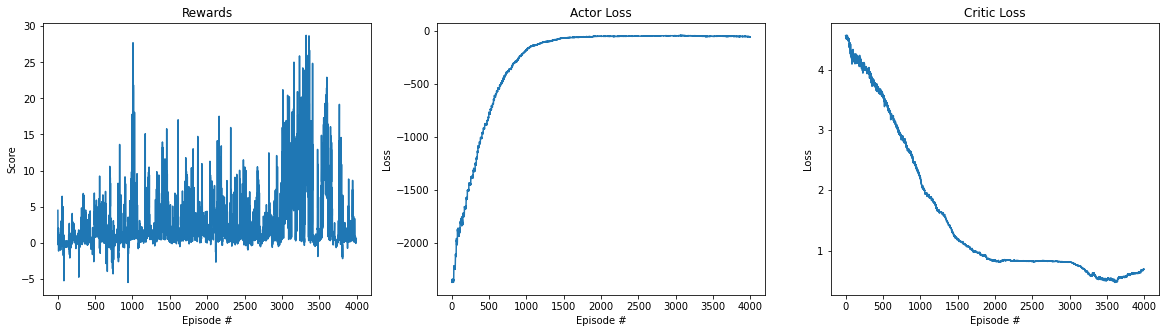

[4.476809797650883,
 0.09024322265759108,
 -0.12453701785610366,
 0.06755016131016117,
 -0.11289852632520098,
 0.26915214001201093,
 -0.32549499658246833,
 0.11835583085970335,
 2.028661526312741,
 0.37983063507514686,
 -1.1650990230652194,
 0.2880131857236847,
 0.5438971275774142,
 0.05019219832805294,
 -0.8740216681423287,
 -0.07195563218556345,
 0.3038518646887193,
 0.08849529436944678,
 0.13246359451053044,
 0.11704329680651421,
 -0.13870748454549656,
 0.12056762290497627,
 1.1098196908133107,
 0.2701966398550818,
 -0.411854983967108,
 -0.12633869179990148,
 0.02874190666868026,
 -0.43994312558788806,
 -0.08750876279858254,
 -0.016733963314133363,
 -0.5773670942289755,
 0.5860093494411557,
 -0.991250143192398,
 0.4650194205266112,
 0.662643028772436,
 -0.15148060031545654,
 0.7598719084635378,
 1.4465394618455318,
 -1.0130895088465575,
 0.5716148457334688,
 1.1481452959123999,
 0.6328998367923001,
 0.9335419435907776,
 -0.4338527510408312,
 3.0099762491105744,
 -0.35255265286347515

In [12]:
####################### 
# Tuning VMax...
#######################

# Params Override: Initialized in params.py
params = Params()
params.random_seed = 0
params.n_episodes=3000
params.max_t = 3000
params.print_every = 100
params.save_every = 100
params.prefill_memory_qty=5000
params.terminate_on_target_score = True
params.plot_stats = True
params.lr_actor = 5e-4                  
params.lr_critic = 1e-3    
params.vmin = 0
params.vmax = 100

#### MAIN #####
logger = Logger(params)
agent = D4PG_Agent(state_size, action_size, params=params)
d4pg(params, logger)


##################
# Params Override: Initialized in params.py
params = Params()
params.random_seed = 0
params.n_episodes=4000
params.max_t = 3000
params.print_every = 100
params.save_every = 100
params.prefill_memory_qty=5000
params.terminate_on_target_score = True
params.plot_stats = True
params.lr_actor = 5e-4                  
params.lr_critic = 1e-3 
params.vmin = 0
params.vmax = 200   

#### MAIN #####
logger = Logger(params)
agent = D4PG_Agent(state_size, action_size, params=params)
d4pg(params, logger)

##################
# Params Override: Initialized in params.py
params = Params()
params.random_seed = 0
params.n_episodes=4000
params.max_t = 3000
params.print_every = 100
params.save_every = 100
params.prefill_memory_qty=5000
params.terminate_on_target_score = True
params.plot_stats = True
params.lr_actor = 5e-4                  
params.lr_critic = 1e-3  
params.vmin = 0
params.vmax = 500


#### MAIN #####
logger = Logger(params)
agent = D4PG_Agent(state_size, action_size, params=params)
d4pg(params, logger)


##################
# Params Override: Initialized in params.py
params = Params()
params.random_seed = 0
params.n_episodes=4000
params.max_t = 3000
params.print_every = 100
params.save_every = 100
params.prefill_memory_qty=5000
params.terminate_on_target_score = True
params.plot_stats = True
params.lr_actor = 5e-4                  
params.lr_critic = 1e-3  
params.vmin = 0
params.vmax = 1000


#### MAIN #####
logger = Logger(params)
agent = D4PG_Agent(state_size, action_size, params=params)
d4pg(params, logger)


##################
# Params Override: Initialized in params.py
params = Params()
params.random_seed = 0
params.n_episodes=4000
params.max_t = 3000
params.print_every = 100
params.save_every = 100
params.prefill_memory_qty=5000
params.terminate_on_target_score = True
params.plot_stats = True
params.lr_actor = 5e-4                  
params.lr_critic = 1e-3  
params.vmin = 0
params.vmax = 2000


#### MAIN #####
logger = Logger(params)
agent = D4PG_Agent(state_size, action_size, params=params)
d4pg(params, logger)


##################
# Params Override: Initialized in params.py
params = Params()
params.random_seed = 0
params.n_episodes=4000
params.max_t = 3000
params.print_every = 100
params.save_every = 100
params.prefill_memory_qty=5000
params.terminate_on_target_score = True
params.plot_stats = True
params.lr_actor = 5e-4                  
params.lr_critic = 1e-3  
params.vmin = 0
params.vmax = 5000


#### MAIN #####
logger = Logger(params)
agent = D4PG_Agent(state_size, action_size, params=params)
d4pg(params, logger)

In [ ]:
# ####################### 
# # More fine-tuning over vMax ...
# #######################

# # Params Override: Initialized in params.py
# params = Params()
# params.random_seed = 0
# params.n_episodes=3000
# params.max_t = 3000
# params.print_every = 100
# params.save_every = 100
# params.prefill_memory_qty=5000
# params.terminate_on_target_score = True
# params.plot_stats = True
# params.lr_actor = 5e-4                  
# params.lr_critic = 1e-3    
# params.vmin = -0.01
# params.vmax = 10

# #### MAIN #####
# logger = Logger(params)
# agent = D4PG_Agent(state_size, action_size, params=params)
# d4pg(params, logger)


# ##################
# # Params Override: Initialized in params.py
# params = Params()
# params.random_seed = 0
# params.n_episodes=4000
# params.max_t = 3000
# params.print_every = 100
# params.save_every = 100
# params.prefill_memory_qty=5000
# params.terminate_on_target_score = True
# params.plot_stats = True
# params.lr_actor = 5e-4                  
# params.lr_critic = 1e-3 
# params.vmin = -0.01
# params.vmax = 15   

# #### MAIN #####
# logger = Logger(params)
# agent = D4PG_Agent(state_size, action_size, params=params)
# d4pg(params, logger)

# ##################
# # Params Override: Initialized in params.py
# params = Params()
# params.random_seed = 0
# params.n_episodes=4000
# params.max_t = 3000
# params.print_every = 100
# params.save_every = 100
# params.prefill_memory_qty=5000
# params.terminate_on_target_score = True
# params.plot_stats = True
# params.lr_actor = 5e-4                  
# params.lr_critic = 1e-3  
# params.vmin = -0.01
# params.vmax = 25

# #### MAIN #####
# logger = Logger(params)
# agent = D4PG_Agent(state_size, action_size, params=params)
# d4pg(params, logger)


# ##################
# # Params Override: Initialized in params.py
# params = Params()
# params.random_seed = 0
# params.n_episodes=4000
# params.max_t = 3000
# params.print_every = 100
# params.save_every = 100
# params.prefill_memory_qty=5000
# params.terminate_on_target_score = True
# params.plot_stats = True
# params.lr_actor = 5e-4                  
# params.lr_critic = 1e-3  
# params.vmin = -0.01
# params.vmax = 30

# #### MAIN #####
# logger = Logger(params)
# agent = D4PG_Agent(state_size, action_size, params=params)
# d4pg(params, logger)


# ##################
# # Params Override: Initialized in params.py
# params = Params()
# params.random_seed = 0
# params.n_episodes=4000
# params.max_t = 3000
# params.print_every = 100
# params.save_every = 100
# params.prefill_memory_qty=5000
# params.terminate_on_target_score = True
# params.plot_stats = True
# params.lr_actor = 5e-4                  
# params.lr_critic = 1e-3  
# params.vmin = -0.01
# params.vmax = 35

# #### MAIN #####
# logger = Logger(params)
# agent = D4PG_Agent(state_size, action_size, params=params)
# d4pg(params, logger)


# ##################
# # Params Override: Initialized in params.py
# params = Params()
# params.random_seed = 0
# params.n_episodes=4000
# params.max_t = 3000
# params.print_every = 100
# params.save_every = 100
# params.prefill_memory_qty=5000
# params.terminate_on_target_score = True
# params.plot_stats = True
# params.lr_actor = 5e-4                  
# params.lr_critic = 1e-3  
# params.vmin = -0.01
# params.vmax = 40

# #### MAIN #####
# logger = Logger(params)
# agent = D4PG_Agent(state_size, action_size, params=params)
# d4pg(params, logger)


# ##################
# # Params Override: Initialized in params.py
# params = Params()
# params.random_seed = 0
# params.n_episodes=4000
# params.max_t = 3000
# params.print_every = 100
# params.save_every = 100
# params.prefill_memory_qty=5000
# params.terminate_on_target_score = True
# params.plot_stats = True
# params.lr_actor = 5e-4                  
# params.lr_critic = 1e-3  
# params.vmin = -0.01
# params.vmax = 45

# #### MAIN #####
# logger = Logger(params)
# agent = D4PG_Agent(state_size, action_size, params=params)
# d4pg(params, logger)


# ##################
# # Params Override: Initialized in params.py
# params = Params()
# params.random_seed = 0
# params.n_episodes=4000
# params.max_t = 3000
# params.print_every = 100
# params.save_every = 100
# params.prefill_memory_qty=5000
# params.terminate_on_target_score = True
# params.plot_stats = True
# params.lr_actor = 5e-4                  
# params.lr_critic = 1e-3  
# params.vmin = -0.01
# params.vmax = 50


# #### MAIN #####
# logger = Logger(params)
# agent = D4PG_Agent(state_size, action_size, params=params)
# d4pg(params, logger)

Experimenting with Learning Rates...

In [ ]:
####################### 
# Increasing Hard Update rates C & buffer size
#######################


##################
# Params Override: Initialized in params.py
params = Params()
params.random_seed = 0
params.n_episodes=5000
params.max_t = 3000
params.print_every = 100
params.save_every = 100
params.prefill_memory_qty=5000
params.terminate_on_target_score = True
params.plot_stats = True
params.lr_actor = 5e-4                  
params.lr_critic = 1e-3 
params.vmin = 0
params.vmax = 200   
params.num_atoms = 100
params.hard_weights_update_every = 1000
params.buffer_size = int(1e6)

#### MAIN #####
logger = Logger(params)
agent = D4PG_Agent(state_size, action_size, params=params)
d4pg(params, logger)


##################
# Params Override: Initialized in params.py
params = Params()
params.random_seed = 0
params.n_episodes=5000
params.max_t = 3000
params.print_every = 100
params.save_every = 100
params.prefill_memory_qty=5000
params.terminate_on_target_score = True
params.plot_stats = True
params.lr_actor = 1e-4                  
params.lr_critic = 1e-3 
params.vmin = 0
params.vmax = 200   
params.num_atoms = 100
params.hard_weights_update_every = 2000
params.buffer_size = int(1e6)

#### MAIN #####
logger = Logger(params)
agent = D4PG_Agent(state_size, action_size, params=params)
d4pg(params, logger)


##################
# Params Override: Initialized in params.py
params = Params()
params.random_seed = 0
params.n_episodes=5000
params.max_t = 3000
params.print_every = 100
params.save_every = 100
params.prefill_memory_qty=5000
params.terminate_on_target_score = True
params.plot_stats = True
params.lr_actor = 1e-4                  
params.lr_critic = 1e-3 
params.vmin = 0
params.vmax = 200   
params.num_atoms = 100
params.hard_weights_update_every = 3000
params.buffer_size = int(1e6)

#### MAIN #####
logger = Logger(params)
agent = D4PG_Agent(state_size, action_size, params=params)
d4pg(params, logger)


=============== HYPERPARAMS ===============
DEVICE:  cuda:0
RANDOM SEED:  0
BUFFER_SIZE:  1000000
BATCH_SIZE:  512
GAMMA:  0.9
TAU:  0.001
LR_ACTOR:  5e-05
LR_CRITIC:  0.0001
WEIGHT_DECAY:  0.0001
HARD_UPDATE:  True
LEARN_EVERY:  1
HARD_WEIGHTS_UPDATE_EVERY:  2000
N_STEP_BOOTSTRAP:  5
VMIN:  -1
VMAX:  200
NUM_ATOMS:  100

Prefilling Replay Memory Buffer: 5004 / 5000
 ===== Replay Buffer prefilled. Agent will begin learning. =====

Episode 100: 	Actor Loss: -4.72 	Critic Loss: 1.17 
		Average Score: 15.23

Episode 200: 	Actor Loss: -5.55 	Critic Loss: 1.08 
		Average Score: 31.42



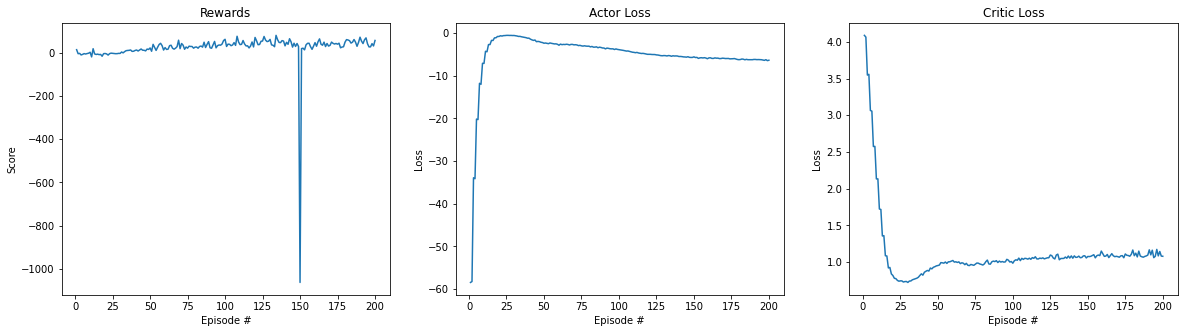


=============== HYPERPARAMS ===============
DEVICE:  cuda:0
RANDOM SEED:  0
BUFFER_SIZE:  1000000
BATCH_SIZE:  512
GAMMA:  0.9
TAU:  0.001
LR_ACTOR:  5e-05
LR_CRITIC:  5e-05
WEIGHT_DECAY:  0.0001
HARD_UPDATE:  True
LEARN_EVERY:  1
HARD_WEIGHTS_UPDATE_EVERY:  2000
N_STEP_BOOTSTRAP:  5
VMIN:  -1
VMAX:  200
NUM_ATOMS:  100

Prefilling Replay Memory Buffer: 5004 / 5000
 ===== Replay Buffer prefilled. Agent will begin learning. =====

Episode 100: 	Actor Loss: -3.43 	Critic Loss: 1.04 
		Average Score: 2.42

Episode 200: 	Actor Loss: -3.76 	Critic Loss: 0.99 
		Average Score: 16.55



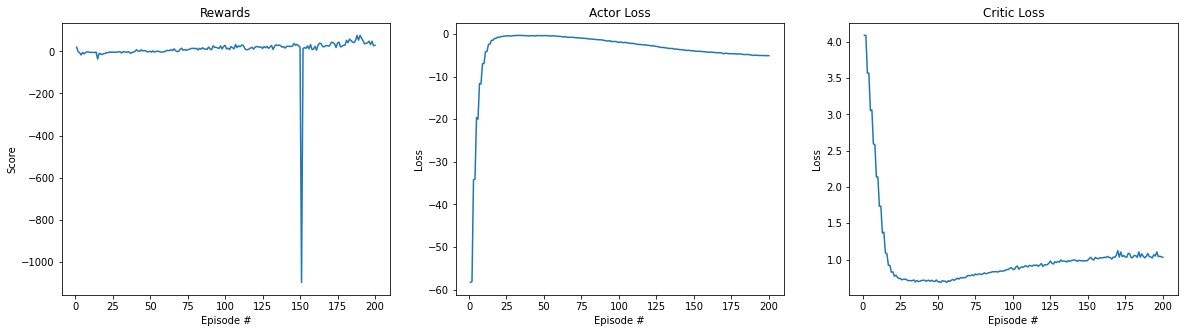


=============== HYPERPARAMS ===============
DEVICE:  cuda:0
RANDOM SEED:  0
BUFFER_SIZE:  1000000
BATCH_SIZE:  512
GAMMA:  0.9
TAU:  0.001
LR_ACTOR:  1e-05
LR_CRITIC:  5e-05
WEIGHT_DECAY:  0.0001
HARD_UPDATE:  True
LEARN_EVERY:  1
HARD_WEIGHTS_UPDATE_EVERY:  2000
N_STEP_BOOTSTRAP:  5
VMIN:  -1
VMAX:  200
NUM_ATOMS:  100

Prefilling Replay Memory Buffer: 5004 / 5000
 ===== Replay Buffer prefilled. Agent will begin learning. =====

Episode 19\ Score: 22.05NaN Reward Found! Converting to R=0 instead...
NaN Reward Found! Converting to R=0 instead...
NaN Reward Found! Converting to R=0 instead...
NaN Reward Found! Converting to R=0 instead...
NaN Reward Found! Converting to R=0 instead...
NaN Reward Found! Converting to R=0 instead...
NaN Reward Found! Converting to R=0 instead...
NaN Reward Found! Converting to R=0 instead...
NaN Reward Found! Converting to R=0 instead...
NaN Reward Found! Converting to R=0 instead...
NaN Reward Found! Converting to R=0 instead...
NaN Reward Found! Conver

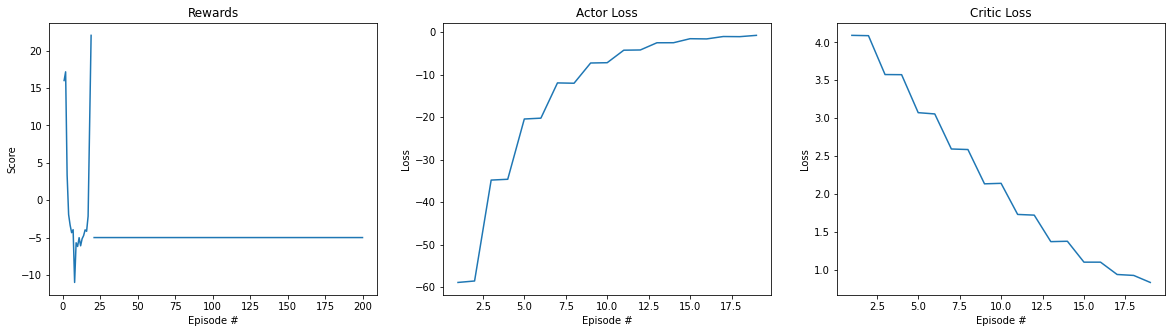

[16.004861294322836,
 17.169842965640175,
 3.3620741892357007,
 -1.9227765432992279,
 -3.335259335911058,
 -4.344993908854829,
 -3.947141599978043,
 -11.00369619594615,
 -5.698460225727307,
 -6.190930830269483,
 -5.013788565016713,
 -6.1007357562743385,
 -5.158827243482746,
 -4.7378689331235355,
 -3.9675092095308675,
 -4.158895326357095,
 -2.139143584869292,
 9.661191419427874,
 22.046775577544196,
 nan,
 -5.0,
 -5.0,
 -5.0,
 -5.0,
 -5.0,
 -5.0,
 -5.0,
 -5.0,
 -5.0,
 -5.0,
 -5.0,
 -5.0,
 -5.0,
 -5.0,
 -5.0,
 -5.0,
 -5.0,
 -5.0,
 -5.0,
 -5.0,
 -5.0,
 -5.0,
 -5.0,
 -5.0,
 -5.0,
 -5.0,
 -5.0,
 -5.0,
 -5.0,
 -5.0,
 -5.0,
 -5.0,
 -5.0,
 -5.0,
 -5.0,
 -5.0,
 -5.0,
 -5.0,
 -5.0,
 -5.0,
 -5.0,
 -5.0,
 -5.0,
 -5.0,
 -5.0,
 -5.0,
 -5.0,
 -5.0,
 -5.0,
 -5.0,
 -5.0,
 -5.0,
 -5.0,
 -5.0,
 -5.0,
 -5.0,
 -5.0,
 -5.0,
 -5.0,
 -5.0,
 -5.0,
 -5.0,
 -5.0,
 -5.0,
 -5.0,
 -5.0,
 -5.0,
 -5.0,
 -5.0,
 -5.0,
 -5.0,
 -5.0,
 -5.0,
 -5.0,
 -5.0,
 -5.0,
 -5.0,
 -5.0,
 -5.0,
 -5.0,
 -5.0,
 -5.0,
 -5.0,
 -5.0,
 -5.

In [12]:
#####
# TRYING OUT THE Learning Rates
#####

# ##################
# # Params Override: Initialized in params.py
# params = Params()
# params.random_seed = 0
# params.n_episodes=10000
# params.max_t = 1000
# params.print_every = 100
# params.save_every = 100
# params.prefill_memory_qty=5000
# params.terminate_on_target_score = True
# params.plot_stats = True
# params.lr_actor = 1e-4                  
# params.lr_critic = 4e-4 
# params.vmin = -1
# params.vmax = 200
# params.num_atoms = 100
# params.hard_weights_update_every = 2000
# params.buffer_size = int(1e5)
# params.gamma = 0.9
# params.batch_size = 128

# #### MAIN #####
# logger = Logger(params)
# agent = D4PG_Agent(state_size, action_size, params=params)
# d4pg(params, logger)

##################
# Params Override: Initialized in params.py
params = Params()
params.random_seed = 0
params.n_episodes=200
params.max_t = 1000
params.print_every = 100
params.save_every = 100
params.prefill_memory_qty=5000
params.terminate_on_target_score = True
params.plot_stats = True
params.lr_actor = 5e-5                  
params.lr_critic = 1e-4 
params.vmin = -1
params.vmax = 200
params.num_atoms = 100
params.hard_weights_update_every = 2000
params.buffer_size = int(1e6)
params.gamma = 0.9
params.batch_size = 512

#### MAIN #####
logger = Logger(params)
agent = D4PG_Agent(state_size, action_size, params=params)
d4pg(params, logger)

##################
# Params Override: Initialized in params.py
params = Params()
params.random_seed = 0
params.n_episodes=200
params.max_t = 1000
params.print_every = 100
params.save_every = 100
params.prefill_memory_qty=5000
params.terminate_on_target_score = True
params.plot_stats = True
params.lr_actor = 5e-5                  
params.lr_critic = 5e-5 
params.vmin = -1
params.vmax = 200
params.num_atoms = 100
params.hard_weights_update_every = 2000
params.buffer_size = int(1e6)
params.gamma = 0.9
params.batch_size = 512

#### MAIN #####
logger = Logger(params)
agent = D4PG_Agent(state_size, action_size, params=params)
d4pg(params, logger)

##################
# Params Override: Initialized in params.py
params = Params()
params.random_seed = 0
params.n_episodes=200
params.max_t = 1000
params.print_every = 100
params.save_every = 100
params.prefill_memory_qty=5000
params.terminate_on_target_score = True
params.plot_stats = True
params.lr_actor = 1e-5                  
params.lr_critic = 5e-5 
params.vmin = -1
params.vmax = 200
params.num_atoms = 100
params.hard_weights_update_every = 2000
params.buffer_size = int(1e6)
params.gamma = 0.9
params.batch_size = 512

#### MAIN #####
logger = Logger(params)
agent = D4PG_Agent(state_size, action_size, params=params)
d4pg(params, logger)

In [9]:
#######################
# SEEMS TO WORK WELL SO FAR... (+130 rewards)
#######################

##################
# Params Override: Initialized in params.py
params = Params()
params.random_seed = 0
params.n_episodes=1000
params.max_t = 1000
params.print_every = 100
params.save_every = 100
params.prefill_memory_qty=10000
params.terminate_on_target_score = True
params.plot_stats = True
params.lr_actor = 1e-5                  
params.lr_critic = 1e-4 
params.vmin = -1
params.vmax = 200
params.num_atoms = 100
params.hard_weights_update_every = 2000
params.buffer_size = int(1e6)
params.gamma = 0.95
params.batch_size = 2048

#### MAIN #####
logger = Logger(params)
agent = D4PG_Agent(state_size, action_size, params=params)
d4pg(params, logger)


=============== HYPERPARAMS ===============
DEVICE:  cuda:0
RANDOM SEED:  0
BUFFER_SIZE:  1000000
BATCH_SIZE:  2048
GAMMA:  0.95
TAU:  0.001
LR_ACTOR:  1e-05
LR_CRITIC:  0.0001
WEIGHT_DECAY:  0.0001
HARD_UPDATE:  True
LEARN_EVERY:  1
HARD_WEIGHTS_UPDATE_EVERY:  2000
N_STEP_BOOTSTRAP:  5
VMIN:  -1
VMAX:  200
NUM_ATOMS:  100

Prefilling Replay Memory Buffer: 10008 / 10000
 ===== Replay Buffer prefilled. Agent will begin learning. =====

Episode 100: 	Actor Loss: -11.96 	Critic Loss: 1.98 
		Average Score: 21.48

Episode 127\ Score: 131.2479

ERROR:root:Exception calling application: pickle data was truncated
Traceback (most recent call last):
  File "C:\Users\derek\anaconda3\envs\drlnd_gpu\lib\site-packages\grpc\_server.py", line 385, in _call_behavior
    return behavior(argument, context), True
  File "C:\Users\derek\anaconda3\envs\drlnd_gpu\lib\site-packages\unityagents\rpc_communicator.py", line 26, in Exchange
    return self.child_conn.recv()
  File "C:\Users\derek\anaconda3\envs\drlnd_gpu\lib\multiprocessing\connection.py", line 251, in recv
    return _ForkingPickler.loads(buf.getbuffer())
_pickle.UnpicklingError: pickle data was truncated
ERROR:root:Exception calling application: 
Traceback (most recent call last):
  File "C:\Users\derek\anaconda3\envs\drlnd_gpu\lib\site-packages\grpc\_server.py", line 385, in _call_behavior
    return behavior(argument, context), True
  File "C:\Users\derek\anaconda3\envs\drlnd_gpu\lib\site-packages\unityagents\rpc_communicator.py", line 26, in Exchange
    return self.child_conn

KeyError: 'CrawlerBrain'

In [30]:
#######################
# SPEEDING THINGS UP
#######################

##################
# Params Override: Initialized in params.py
params = Params()
params.random_seed = 0
params.n_episodes=1000
params.max_t = 1000
params.print_every = 100
params.save_every = 100
params.prefill_memory_qty=10000
params.terminate_on_target_score = True
params.plot_stats = True
params.lr_actor = 1e-5                  
params.lr_critic = 1e-4 
params.vmin = -1
params.vmax = 200
params.num_atoms = 100
params.hard_weights_update_every = 2000
params.buffer_size = int(1e6)
params.gamma = 0.95
params.batch_size = 2048

#### MAIN #####
logger = Logger(params)
agent = D4PG_Agent(state_size, action_size, params=params)
d4pg(params, logger)

# #####
# # REWARDS GETS NAN AT 130 EPOCHS
# ##################
# # Params Override: Initialized in params.py
# params = Params()
# params.random_seed = 0
# params.n_episodes=1000
# params.max_t = 1000
# params.print_every = 100
# params.save_every = 100
# params.prefill_memory_qty=100
# params.terminate_on_target_score = True
# params.plot_stats = True
# params.lr_actor = 1e-5                  
# params.lr_critic = 1e-4 
# params.vmin = -1
# params.vmax = 200
# params.num_atoms = 100
# params.hard_weights_update_every = 2000
# params.buffer_size = int(1e6)
# params.gamma = 0.95
# params.batch_size = 512

# #### MAIN #####
# logger = Logger(params)
# agent = D4PG_Agent(state_size, action_size, params=params)
# d4pg(params, logger)


=============== HYPERPARAMS ===============
DEVICE:  cuda:0
RANDOM SEED:  0
BUFFER_SIZE:  1000000
BATCH_SIZE:  2048
GAMMA:  0.95
TAU:  0.001
LR_ACTOR:  1e-05
LR_CRITIC:  0.0001
WEIGHT_DECAY:  0.0001
HARD_UPDATE:  True
LEARN_EVERY:  1
HARD_WEIGHTS_UPDATE_EVERY:  2000
N_STEP_BOOTSTRAP:  5
VMIN:  -1
VMAX:  200
NUM_ATOMS:  100

Prefilling Replay Memory Buffer: 10008 / 10000
 ===== Replay Buffer prefilled. Agent will begin learning. =====

Episode 88\ Score: 155.47NaN Reward Found! Converting to R=0 instead...
NaN Reward Found! Converting to R=0 instead...
NaN Reward Found! Converting to R=0 instead...
NaN Reward Found! Converting to R=0 instead...
NaN Reward Found! Converting to R=0 instead...
NaN Reward Found! Converting to R=0 instead...
NaN Reward Found! Converting to R=0 instead...
NaN Reward Found! Converting to R=0 instead...
NaN Reward Found! Converting to R=0 instead...
NaN Reward Found! Converting to R=0 instead...
NaN Reward Found! Converting to R=0 instead...
NaN Reward Found! 

NaN Reward Found! Converting to R=0 instead...
NaN Reward Found! Converting to R=0 instead...
NaN Reward Found! Converting to R=0 instead...
NaN Reward Found! Converting to R=0 instead...
NaN Reward Found! Converting to R=0 instead...
NaN Reward Found! Converting to R=0 instead...
NaN Reward Found! Converting to R=0 instead...
NaN Reward Found! Converting to R=0 instead...
NaN Reward Found! Converting to R=0 instead...
NaN Reward Found! Converting to R=0 instead...
NaN Reward Found! Converting to R=0 instead...
NaN Reward Found! Converting to R=0 instead...
NaN Reward Found! Converting to R=0 instead...
NaN Reward Found! Converting to R=0 instead...
NaN Reward Found! Converting to R=0 instead...
NaN Reward Found! Converting to R=0 instead...
NaN Reward Found! Converting to R=0 instead...
NaN Reward Found! Converting to R=0 instead...
NaN Reward Found! Converting to R=0 instead...
NaN Reward Found! Converting to R=0 instead...
NaN Reward Found! Converting to R=0 instead...
NaN Reward Fo

NaN Reward Found! Converting to R=0 instead...
NaN Reward Found! Converting to R=0 instead...
NaN Reward Found! Converting to R=0 instead...
NaN Reward Found! Converting to R=0 instead...
NaN Reward Found! Converting to R=0 instead...
NaN Reward Found! Converting to R=0 instead...
NaN Reward Found! Converting to R=0 instead...
NaN Reward Found! Converting to R=0 instead...
NaN Reward Found! Converting to R=0 instead...
NaN Reward Found! Converting to R=0 instead...
NaN Reward Found! Converting to R=0 instead...
NaN Reward Found! Converting to R=0 instead...
NaN Reward Found! Converting to R=0 instead...
NaN Reward Found! Converting to R=0 instead...
NaN Reward Found! Converting to R=0 instead...
NaN Reward Found! Converting to R=0 instead...
NaN Reward Found! Converting to R=0 instead...
NaN Reward Found! Converting to R=0 instead...
NaN Reward Found! Converting to R=0 instead...
NaN Reward Found! Converting to R=0 instead...
NaN Reward Found! Converting to R=0 instead...
NaN Reward Fo

KeyboardInterrupt: 

In [ ]:
#################
#EXPERIMENTING WITH HIGH VMAX
#################

##################
# Params Override: Initialized in params.py
params = Params()
params.random_seed = 0
params.n_episodes=1000
params.max_t = 1000
params.print_every = 100
params.save_every = 100
params.prefill_memory_qty=10000
params.terminate_on_target_score = True
params.plot_stats = True
params.lr_actor = 1e-5                  
params.lr_critic = 1e-4 
params.vmin = -1
params.vmax = 2000
params.num_atoms = 100
params.hard_weights_update_every = 2000
params.buffer_size = int(1e6)
params.gamma = 0.95
params.batch_size = 512

#### MAIN #####
logger = Logger(params)
agent = D4PG_Agent(state_size, action_size, params=params)
d4pg(params, logger)


=============== HYPERPARAMS ===============
DEVICE:  cuda:0
RANDOM SEED:  0
BUFFER_SIZE:  1000000
BATCH_SIZE:  512
HIDDEN_SIZES:  (256, 128)
GAMMA:  0.95
TAU:  0.001
LR_ACTOR:  1e-05
LR_CRITIC:  0.0001
WEIGHT_DECAY:  0.0001
HARD_UPDATE:  True
LEARN_EVERY:  1
HARD_WEIGHTS_UPDATE_EVERY:  2000
N_STEP_BOOTSTRAP:  5
VMIN:  -1
VMAX:  2000
NUM_ATOMS:  100

Prefilling Replay Memory Buffer: 10008 / 10000
 ===== Replay Buffer prefilled. Agent will begin learning. =====



### 4. Watch a Smart Agent!

In the next code cell, you will load the trained weights from file to watch a smart agent!

In [ ]:
# load the weights from file
params = Params()
logger = Logger(params)
agent = D4PG_Agent(state_size, action_size, params=params)
agent.actor_local.load_state_dict(torch.load('weights/saved/actor_atom100_ep300.pth'))
agent.critic_local.load_state_dict(torch.load('weights/saved/critic_atom100_ep300.pth'))


env_info = env.reset(train_mode=False)[brain_name]     # reset the environment
states = env_info.vector_observations                # get the current state
score = 0                                              # initialize the score
while True:
    # Perform actions from each agent's policy network (clipped actions [0, -1])
    actions = [ agent.act(state, add_noise=False) for state in states ]  
    actions = np.stack(actions)      
    env_info = env.step(actions)[brain_name]  # send the action to the environment 
    next_states = env_info.vector_observations       # get the next state
    rewards = env_info.rewards                       # get the reward
    dones = env_info.local_done                      # see if episode has finished
    score += max(rewards)                                    # update the score
    states = next_states                                 # roll over the state to next time step
    if any(dones):                                           # exit loop if episode finished
        break
    
print("Score: {}".format(score))

When finished, you can close the environment.

In [ ]:
# env.close()